In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import iqr, shapiro
import scipy.stats as st

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV 
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score


import warnings

folder = "D:/Openclassrooms_DataScientist/Projet_3/donnees/"

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 400)

In [2]:
df = pd.read_csv(folder+'data_2.csv', index_col=0)
df.head()

,Quartier,AgeBatiment,NombreUtilisations,PremierTypePropriete,NombreBatiments,NombreEtages,SurfacePlancherTotal,SurfaceTotaleParking,SurfaceTotaleHorsParking,ListeUtilisationsBatiment,UtilisationPrincipale,SurfaceUtilisationPrincipale,UtilisationSecondaire,SurfaceUtilisationSecondaire,UtilisationTertiaire,SurfaceUtilisationTertiaire,Conformité,ConsoSite/S(kBtu/sf),ConsoSiteNorm/S(kBtu/sf),ConsoSource/S(kBtu/sf),ConsoSourceNorm/S(kBtu/sf),ConsoSiteTot(kBtu),ConsoSiteTotNorm(kBtu),Vapeur(kBtu),Électricité(kBtu),GazNaturel(kBtu),EmissionGES,IntensiteGES/S,TrancheAge,Pertes/S(kBtu/sf),ProportionVapeur,ProportionElectricité,ProportionGazNaturel
0,DOWNTOWN,89,1,Hotel,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,Aucune,0.0,Aucune,0.0,Compliant,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,3946027.0,1276453.0,249.98,2.83,"[87,116[",100.800003,0.277302,0.546060,0.176638
1,DOWNTOWN,20,3,Hotel,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,Compliant,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,3242851.0,5145082.0,295.86,2.86,"[0,29[",81.300003,0.000000,0.386609,0.613391
2,DOWNTOWN,47,1,Hotel,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,Aucune,0.0,Aucune,0.0,Compliant,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,49526664.0,1493800.0,2089.28,2.19,"[29,58[",145.899994,0.297113,0.682307,0.020579
3,DOWNTOWN,90,1,Hotel,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,Aucune,0.0,Aucune,0.0,Compliant,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,2768924.0,1811213.0,286.43,4.67,"[87,116[",105.399994,0.325913,0.407519,0.266567
4,DOWNTOWN,36,3,Hotel,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,Compliant,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,5368607.0,8803998.0,505.01,2.88,"[29,58[",96.599991,0.000000,0.378802,0.621198


In [3]:
data = pd.read_csv(folder+'df_new.csv', index_col=0)
data = data.drop(columns=['NombreEtages', 'NombreBatiments', 'Conformité'])

# definition de la variable cible
target = 'ConsoSite/S(kBtu/sf)'
data

,Zone,Utilisation,NombreUtilisations,SurfacePlancherTotal,ConsoSite/S(kBtu/sf),AgeBatiment
0,Centre,Détente,1,88434,81.699997,89
1,Centre,Détente,3,103566,94.800003,20
2,Centre,Détente,1,956110,96.000000,47
3,Centre,Détente,1,61320,110.800003,90
4,Centre,Détente,3,175580,114.800003,36
...,...,...,...,...,...,...
3370,Sud,Autre,1,18261,51.000000,34
3372,Centre,Autre,1,16000,59.400002,12
3373,Centre,Autre,3,13157,438.200012,42
3374,Sud,Autre,5,14101,51.000000,27


In [4]:
'''data['ConsoSiteTot(kBtu)'] = df['ConsoSiteTot(kBtu)']
target = 'ConsoSiteTot(kBtu)'
data = data.drop(columns='ConsoSite/S(kBtu/sf)')
data'''

"data['ConsoSiteTot(kBtu)'] = df['ConsoSiteTot(kBtu)']\ntarget = 'ConsoSiteTot(kBtu)'\ndata = data.drop(columns='ConsoSite/S(kBtu/sf)')\ndata"

# Modèle avec sklearn

In [5]:
var = data.drop(columns=target).columns

In [6]:
# colonnes categ
var_categ = list(data.select_dtypes(include='object').columns)

# data categ 2
data_categ = data.select_dtypes(include='object')
data_categ

,Zone,Utilisation
0,Centre,Détente
1,Centre,Détente
2,Centre,Détente
3,Centre,Détente
4,Centre,Détente
...,...,...
3370,Sud,Autre
3372,Centre,Autre
3373,Centre,Autre
3374,Sud,Autre


In [7]:
# catégories
categories = []
for col in data_categ:
    for element in data_categ[col].unique():
        categories.append(element)
categories

['Centre',
 'Nord',
 'Sud',
 'Détente',
 'Autre',
 'Universitaire',
 'Bureau',
 'Industriel',
 'Médical',
 'Supermarché']

In [8]:
# colonnes num
var_num = list(data.drop(columns=target).select_dtypes(exclude='object').columns)

# data num 2
data_num = data.drop(columns=target).select_dtypes(exclude='object')
data_num

,NombreUtilisations,SurfacePlancherTotal,AgeBatiment
0,1,88434,89
1,3,103566,20
2,1,956110,47
3,1,61320,90
4,3,175580,36
...,...,...,...
3370,1,18261,34
3372,1,16000,12
3373,3,13157,42
3374,5,14101,27


In [9]:
# création du train et test set
data_train, data_test = train_test_split(data, test_size=0.2)

print(f"Les dimensions du train_set sont {data_train.shape}")
print(f"Les dimensions du test_set sont {data_test.shape}")

Les dimensions du train_set sont (1219, 6)
Les dimensions du test_set sont (305, 6)


In [10]:
# creation preprocessor
categ_pipeline = make_pipeline(OneHotEncoder())
#pipeline_selection = make_pipeline(SelectKBest(f_regression, k=5))
#num_pipeline = make_pipeline(PolynomialFeatures(2))
    
preprocessor = make_column_transformer((categ_pipeline, var_categ),                                    
                                       remainder='passthrough')

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['Zone', 'Utilisation'])])

In [11]:
def X_y(data, target):
    
    y = data[[target]]
    X = data.drop(columns=target)
    
    return X, y

In [12]:
# creation des jeux d'entrainement et de test
X_train, y_train = X_y(data_train, target)
X_test, y_test = X_y(data_test, target)

## Modélisation

In [58]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

In [46]:
LinearRegression = make_pipeline(preprocessor, LinearRegression())
Ridge = make_pipeline(preprocessor, Ridge())
Lasso = make_pipeline(preprocessor, Lasso())
ElasticNet = make_pipeline(preprocessor, ElasticNet())

#### Optimisation Ridge

grid.best_score_ : 0.12105134911013611
grid.best_params_ : {'ridge__alpha': 8.286427728546842}
Score meilleur estimateur sur test set : 0.03814782220385449


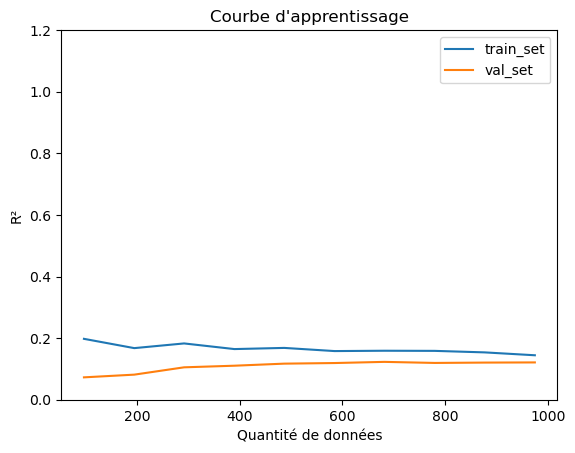

In [47]:
# reglage des hyperparamètres avec GridsearchCv pour le Ridge
alphas = np.logspace(-5, 5, 50)
param_grid = {'ridge__alpha' : alphas}

grid = GridSearchCV(estimator=Ridge, param_grid=param_grid, cv=5)

grid.fit(X_train, y_train)

print('grid.best_score_ :',grid.best_score_)
print('grid.best_params_ :',grid.best_params_)
print('Score meilleur estimateur sur test set :',grid.best_estimator_.score(X_test, y_test))

# courbe d'apprentissage du meilleur estimateur
N, train_score, val_score = learning_curve(grid.best_estimator_, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5)

plt.title(f"Courbe d'apprentissage")
plt.plot(N, train_score.mean(axis=1), label='train_set')
plt.plot(N, val_score.mean(axis=1), label='val_set')
plt.xlabel("Quantité de données")
plt.ylabel("R²")
plt.ylim((0,1.2))
plt.legend()
plt.show()

#### Optimisation Lasso

grid.best_score_ : 0.12036431452268588
grid.best_params_ : {'lasso__alpha': 0.19306977288832497}
Score meilleur estimateur sur test set : 0.03766005815735174


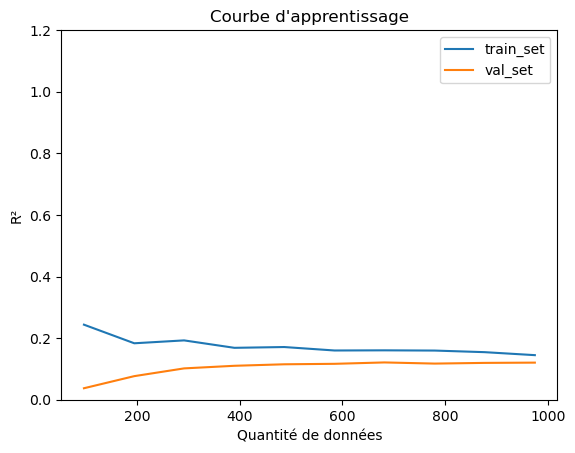

In [49]:
# reglage des hyperparamètres avec GridsearchCv pour le Ridge
alphas = np.logspace(-5, 5, 50)
param_grid = {'lasso__alpha' : alphas}

grid = GridSearchCV(estimator=Lasso, param_grid=param_grid, cv=5)

grid.fit(X_train, y_train)

print('grid.best_score_ :',grid.best_score_)
print('grid.best_params_ :',grid.best_params_)
print('Score meilleur estimateur sur test set :',grid.best_estimator_.score(X_test, y_test))

# courbe d'apprentissage du meilleur estimateur
N, train_score, val_score = learning_curve(grid.best_estimator_, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5)

plt.title(f"Courbe d'apprentissage")
plt.plot(N, train_score.mean(axis=1), label='train_set')
plt.plot(N, val_score.mean(axis=1), label='val_set')
plt.xlabel("Quantité de données")
plt.ylabel("R²")
plt.ylim((0,1.2))
plt.legend()
plt.show()

#### Optimisation ElasticNet

In [53]:
ElasticNet.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Zone', 'Utilisation'])])),
                ('elasticnet', ElasticNet())])>

grid.best_score_ : 0.12165435358642471
grid.best_params_ : {'elasticnet__alpha': 0.19306977288832497, 'elasticnet__l1_ratio': 0.9591836734693877}
Score meilleur estimateur sur test set : 0.04384829331369822


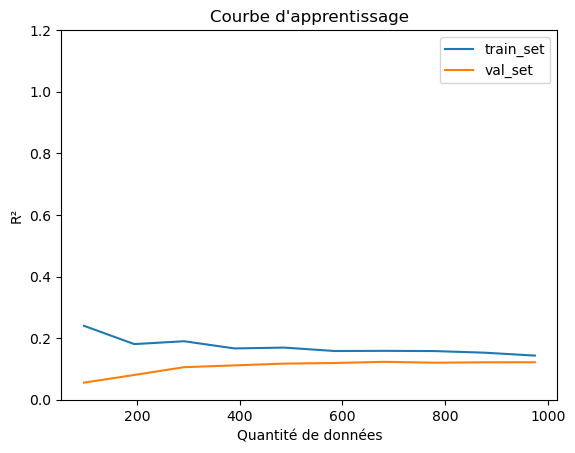

In [56]:
# reglage des hyperparamètres avec GridsearchCv pour le Ridge
alphas = np.logspace(-5, 5, 50)
l1_ratio = np.linspace(0,1,50)
param_grid = {'elasticnet__alpha' : alphas,
             'elasticnet__l1_ratio' : l1_ratio}

grid = GridSearchCV(estimator=ElasticNet, param_grid=param_grid, cv=5)

grid.fit(X_train, y_train)

print('grid.best_score_ :',grid.best_score_)
print('grid.best_params_ :',grid.best_params_)
print('Score meilleur estimateur sur test set :',grid.best_estimator_.score(X_test, y_test))

# courbe d'apprentissage du meilleur estimateur
N, train_score, val_score = learning_curve(grid.best_estimator_, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5)

plt.title(f"Courbe d'apprentissage")
plt.plot(N, train_score.mean(axis=1), label='train_set')
plt.plot(N, val_score.mean(axis=1), label='val_set')
plt.xlabel("Quantité de données")
plt.ylabel("R²")
plt.ylim((0,1.2))
plt.legend()
plt.show()

### Comparaison Modèle non optimisé

In [59]:
LinearRegression = make_pipeline(preprocessor, LinearRegression())
Ridge = make_pipeline(preprocessor, Ridge())
Lasso = make_pipeline(preprocessor, Lasso())
ElasticNet = make_pipeline(preprocessor, ElasticNet())
RandomForest = make_pipeline(preprocessor, RandomForestRegressor(random_state=12))
AdaBoost = make_pipeline(preprocessor, AdaBoostRegressor(random_state=12))
SVR = make_pipeline(preprocessor, SVR())
KNN = make_pipeline(preprocessor, KNeighborsRegressor())

models = {'LinearRegression': LinearRegression, 
          'Ridge': Ridge, 
          'Lasso': Lasso, 
          'ElasticNet': ElasticNet}

for name, model in models.items():
    print(name,':')
    model.fit(X_train, y_train)
    print(cross_val_score(model, X_train, y_train, cv=5))
    print(model.score(X_test, y_test))
    print('_'*100)

LinearRegression :
[0.09799463 0.1598693  0.16800586 0.09418533 0.07921733]
0.03108126889403917
____________________________________________________________________________________________________
Ridge :
[0.09854298 0.15970188 0.16735601 0.09428777 0.08067355]
0.03208636214511418
____________________________________________________________________________________________________
Lasso :
[0.11225148 0.13392185 0.14181048 0.08344126 0.09554151]
0.0535566278171723
____________________________________________________________________________________________________
ElasticNet :
[0.04847312 0.06982253 0.07669131 0.04060999 0.08462669]
0.024824320413818213
____________________________________________________________________________________________________


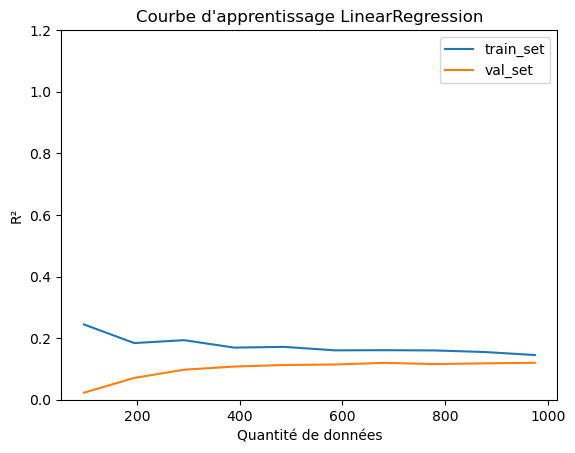

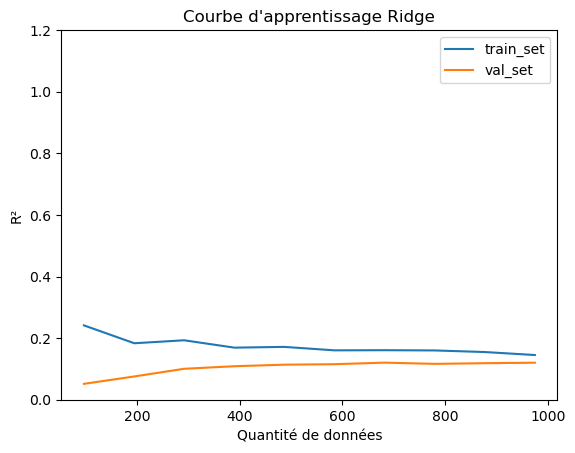

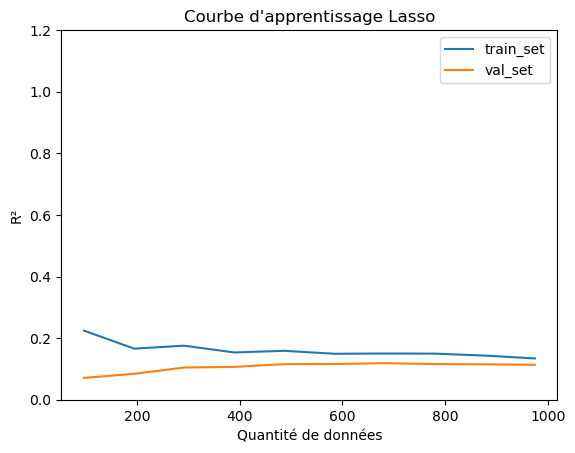

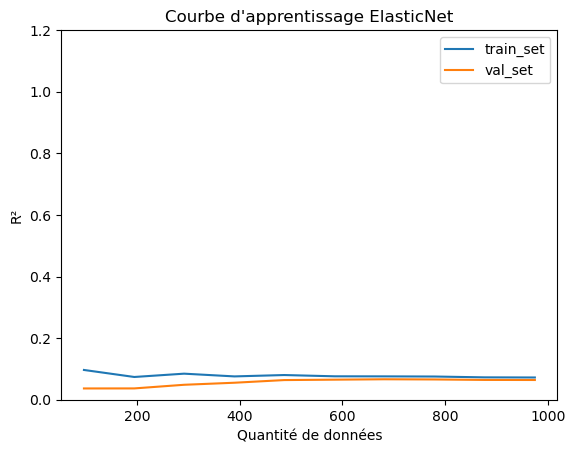

In [24]:
# courbe d'apprentissage
warnings.simplefilter('ignore')

for name, model in models.items():
    N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5)

    plt.title(f"Courbe d'apprentissage {name}")
    plt.plot(N, train_score.mean(axis=1), label='train_set')
    plt.plot(N, val_score.mean(axis=1), label='val_set')
    plt.xlabel("Quantité de données")
    plt.ylabel("R²")
    plt.ylim((0,1.2))
    plt.legend()
    plt.show()